In [1]:
import math
import numpy as np


<br>
Toy model of an on-chain ecosystem with two tokens and one DEX.<br>
Transactions on the DEX create an opportunity for sandwich attacks.<br>


Part 0: Uniswap the easy way<br>
This is the basic Uniswap v2 rule

In [2]:
def pool_swap(poolA, poolB, amtA):
    # Solve the constant product poolA*poolB == (poolA+amtA)*(poolB+amtB)
    # Convention: +amtA means amtA is added to the pool
    amtB = poolA*poolB / (poolA + amtA) - poolB
    assert np.isclose(poolA*poolB, (poolA + amtA)*(poolB + amtB))

    # Truncate to 4 decimal places
    return round(amtB*1e4)/1e4


The first simple chain will have one fixed pool,<br>
  one transaction type (swap),<br>
two people with initial accounts,


In [3]:
class Chain():
    def __init__(self):
        self.poolA = 1000.
        self.poolB = 1000.
        self.accounts = {"alice": [100.,100.],
                         "bob":   [100.,100.],
                         "searcher": [1000.,1000.]}
    def pool_price(self):
        # What is the instantaneous price?
        return 1./(self.poolA / self.poolB)
    def apply_or_continue(self, tx, debug=False):
        try: return self.apply(tx)
        except ExecutionException as e:
            if debug: print(e)
    def apply(self, tx):
        # Apply the transaction, updating the pool price
        if (tx['type'] == 'swap'):
            if tx['qty'] >= 0:
                # Sell qty of tokenA, buy at least rsv of tokenB
                amtA = tx['qty']
                amtB = pool_swap(self.poolA, self.poolB, amtA)
                assert (self.accounts[tx['sndr']][0] >= amtA, 'not enough balance for trade')
                assert (amtB <= 0)
                assert (-amtB >= tx['rsv'], f"slippage exceeded -amtB:{-amtB}, rsv:{tx['rsv']}")
                assert (self.poolB + amtB >= 0, 'exhausts pool')
            else:
                # Sell qty of tokenB, buy at least rsv of tokenA
                amtB = -tx['qty']
                amtA = pool_swap(self.poolB, self.poolA, amtB)
                assert (self.accounts[tx['sndr']][1] >= amtB, 'not enough balance for trade')
                assert (amtA <= 0)
                assert (-amtA >= tx['rsv'], f"slippage exceeded -amtA:{-amtA}, rsv:{tx['rsv']}")
                assert (self.poolA + amtA >= 0, 'exhausts pool')
            self.poolA += amtA
            self.poolB += amtB
            self.accounts[tx['sndr']][0] -= amtA
            self.accounts[tx['sndr']][1] -= amtB
        else:
            raise ValueError("unknown tx type")

<>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:30: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_57899/1315106974.py:22: SyntaxWarning: assertion is always true, perhaps 

In [4]:
def create_swap(sndr,qty,rsv=0.):
    # TODO: auth should do something helpful w/ account nonce, tx hash?
    return dict(type="swap",sndr=sndr,qty=qty,rsv=rsv,auth="auth")


<br>
The first scenario just creates a fixed interaction<br>


In [5]:
def scenario1():
    chain = Chain()
    print('Chain at genesis:')
    print(chain.accounts, chain.poolA, chain.poolB)    

    # Sell 10 units of Token A, receiving at least 7 back of Token B
    tx1 = create_swap("alice", 10, 7)
    chain.apply(tx1)
    
    print('Chain after Alice sells 10 tokenA:')
    print(chain.accounts, chain.poolA, chain.poolB)
    
    # Sell 10 units of Token A, receiving at least 7 back of Token B
    tx2 = create_swap("bob",  10, 7)
    chain.apply(tx2)
    print('Chain after Bob sells 10 tokenA:')
    print(chain.accounts, chain.poolA, chain.poolB)    

In [6]:
scenario1()    

Chain at genesis:
{'alice': [100.0, 100.0], 'bob': [100.0, 100.0], 'searcher': [1000.0, 1000.0]} 1000.0 1000.0
Chain after Alice sells 10 tokenA:
{'alice': [90.0, 109.901], 'bob': [100.0, 100.0], 'searcher': [1000.0, 1000.0]} 1010.0 990.099
Chain after Bob sells 10 tokenA:
{'alice': [90.0, 109.901], 'bob': [90.0, 109.7069], 'searcher': [1000.0, 1000.0]} 1020.0 980.3921


Part II: Let's simulate some trades


<br>
Let's generate trades and report utility over time.<br>
The main idea is that we add noise to the utility functions / preferences.<br>
of the players. <br>
In this way, they get immediate benefit by trading with the AMM.<br>
Because the noise we add is uncorrelated, they often end up arbitraging<br>
each other.<br>


In [7]:
import matplotlib.pyplot as plt

In [8]:
def scenario2(do_trades=True, do_frontruns=False):
    # Preferences are expressed as utility weights over tokens.
    # These can drift over time
    preferences = {"alice":[1.01,0.99],  # Alice would prefer to buy tokenA
                   "bob"  :[1.0,1.0],
                   "searcher": [1.0,1.0]}
    def utility(pref, portfolio):
        assert len(pref) == len(portfolio) == 2
        return pref[0] * portfolio[0] + pref[1] * portfolio[1]
    chain = Chain()
    num_iters = 100
    driftAlice = np.exp(np.random.normal(loc=0., scale=1e-2, size=num_iters))
    driftBob   = np.exp(np.random.normal(loc=0., scale=1e-2, size=num_iters))

    # Measure the social welfare due to use of the AMM
    net_utility_due_to_trades = 0.0
    diffs_alice = []
    diffs_bob   = []
    utils_alice = []
    utils_bob   = []
    xs = []
    poolAs = []
    poolBs = []
    searchers = []
    for i in range(num_iters):

        # Sample a drift in preferences
        preferences['alice'][0] = round(    preferences['alice'][0]*driftAlice[i]*1e3)/1e3
        preferences['alice'][1] = round(1.0/preferences['alice'][0]              *1e3)/1e3
        preferences['bob'  ][0] = round(    preferences['bob'  ][0]*driftBob[i]  *1e3)/1e3
        preferences['bob'  ][1] = round(1.0/preferences['bob'  ][0]              *1e3)/1e3

        # The party tries to trade, in the direction of the top-of-block price
        def make_trade(sndr,prefs,portf):
            my_price = prefs[0] / prefs[1]
            pool_price = 1./ (chain.poolA / chain.poolB)
            
            # Trade just a wee bit, compute a slippage limit based on reserve price
            if pool_price > 1.00001 * my_price:
                # Want to sell A
                qty =  3.e0
                slip = round((-qty / my_price) * 1e3) / 1e3
            elif pool_price < 0.99999 * my_price:
                # Want to sell B
                qty = -3.e0
                slip = round((qty * my_price) * 1e3) / 1e3
            else:
                qty = 0
                slip = 0
            return create_swap(sndr, qty, slip)

        # Record both utilities before
        util_a_old = utility(preferences['alice'], chain.accounts['alice'])
        util_b_old = utility(preferences['bob'  ], chain.accounts['bob'  ])
        txA = make_trade('alice', preferences['alice'], chain.accounts['alice'])        
        txB = make_trade('bob'  , preferences['bob'  ], chain.accounts['bob'  ])

        # Record searcher portfolio
        searcher_old = chain.accounts['searcher']
        if do_trades and not do_frontruns:
            # Apply Alice's trade then Bob's trade
            chain.apply_or_continue(txA)
            chain.apply_or_continue(txB)
        elif do_frontruns:
            # Let the searcher try a sandwich
            txFrA,txBrA = make_sandwich(chain, txA)
            chain.apply_or_continue(txFrA)
            chain.apply_or_continue(txA)
            chain.apply_or_continue(txBrA)

            # Let the searcher try another sandwich
            txFrB,txBrB = make_sandwich(chain, txB)
            chain.apply_or_continue(txFrB)
            chain.apply_or_continue(txB)
            chain.apply_or_continue(txBrB)
            

        # Record both utilities after
        util_a_new = utility(preferences['alice'], chain.accounts['alice'])
        util_b_new = utility(preferences['bob'  ], chain.accounts['bob'  ])
        
        searcher_new = utility(preferences['searcher'], chain.accounts['searcher'])-2000
        
        poolAs.append(chain.poolA)
        poolBs.append(chain.poolB)
        utils_alice.append(util_a_new)
        utils_bob  .append(util_b_new)
        diffs_alice.append(util_a_new-util_a_old)
        diffs_bob  .append(util_b_new-util_b_old)
        searchers.append(searcher_new)
        xs.append(i)

        # Did my utility increase?
        net_utility_due_to_trades += \
            (util_a_new - util_a_old) + \
            (util_b_new - util_b_old)

    # Draw the immediate net change in utility due to trading
    plt.figure(0)
    plt.clf()
    plt.plot(xs,diffs_alice,xs,diffs_bob)
    plt.xlabel('iter')
    plt.ylabel('net utility')
    plt.title(f'net utility after trading (trading:{do_trades}')
    plt.ylim(ymin=-0.05)
    plt.legend(['alice','bob','searcher'])

    # Draw the overall social welfare (sums of utility)
    plt.figure(1)
    plt.clf()
    plt.plot(xs,utils_alice,xs,utils_bob,xs,np.array(searchers)+150)
    plt.xlabel('iter')
    plt.ylabel('utility')
    plt.title('utility over time')
    plt.legend(['alice','bob','searcher'])
    plt.show()

    # Maximal front-run?
    plt.figure(2)
    plt.clf()
    plt.plot(xs,np.array(searchers))
    plt.xlabel('iter')
    plt.ylabel('total units')
    plt.title('net utility to searcher')
    if 0:
        # Scatter plot the pool prices
        plt.figure(2)
        plt.clf()
        plt.title('pool reserves')
        plt.scatter(poolAs,poolBs)
        plt.ylim([0,1200])
        plt.xlim([0,1200])
    print('Surplus distributed to searcher: ', searchers[-1])

Scenario 3: sandwiches


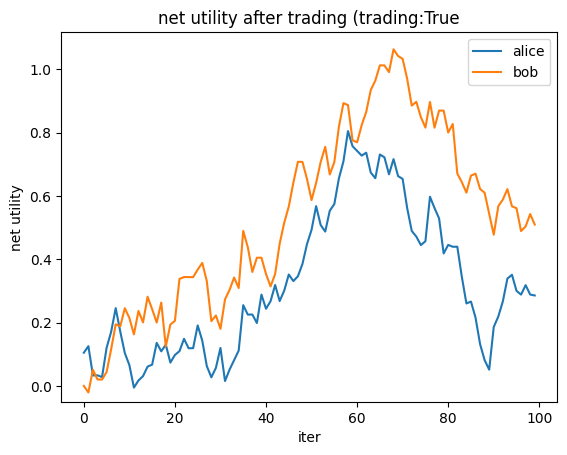

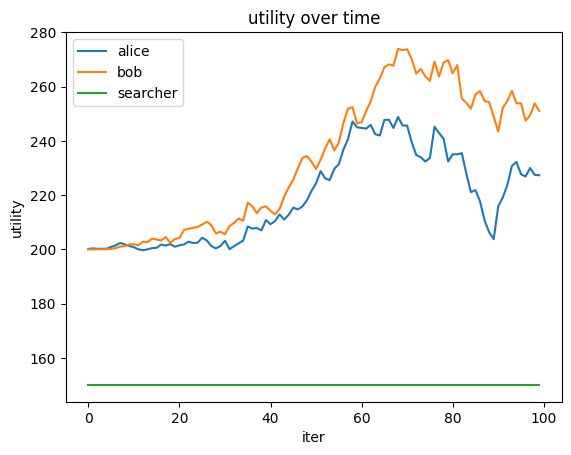

Surplus distributed to searcher:  0.0


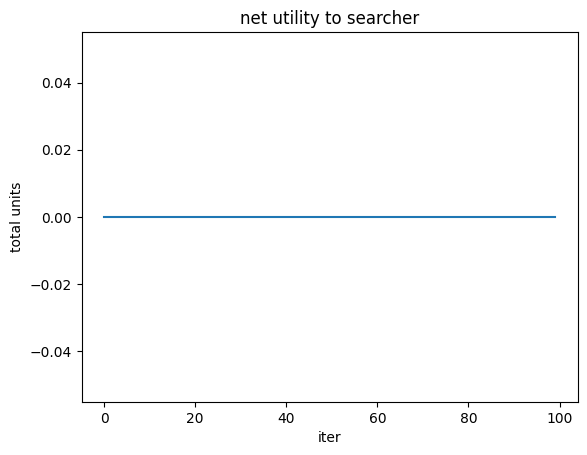

In [9]:
print('Scenario 3: sandwiches')
scenario2(do_trades=True)

Part III: Sandwich Time!


<br>
Can you solve for the optimal front-run?<br>


In [10]:
def make_sandwich(chain, tx):
    """
    args: 
      chain: a copy of the current chainstate
      tx_victim: dict(type="swap",sender=_, qty=_, rsv=_}
    returns (tx_front, tx_back):
      tx_front: a front run swap
      tx_back: a backrun swap
    """
    # Hint: create a Chain() copy
    # Hint: try bisection search

    # Is this stat arb???
    txFr = create_swap('searcher',qty=2)
    txBr = create_swap('searcher',qty=-2)
    return txFr, txBr

Scenario 3: sandwiches


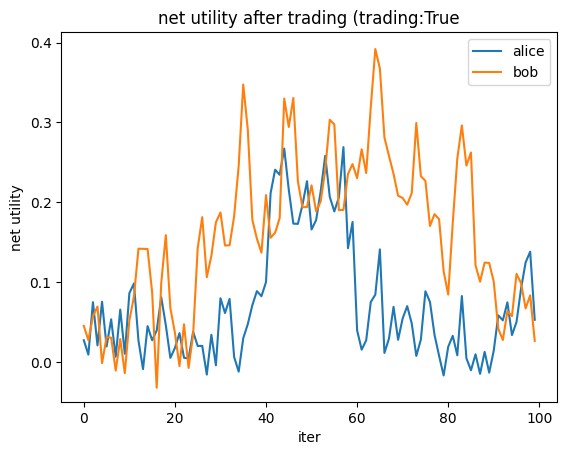

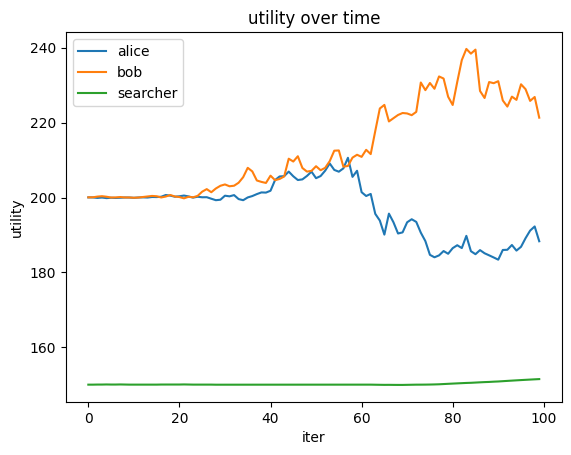

Surplus distributed to searcher:  1.4842000000003281


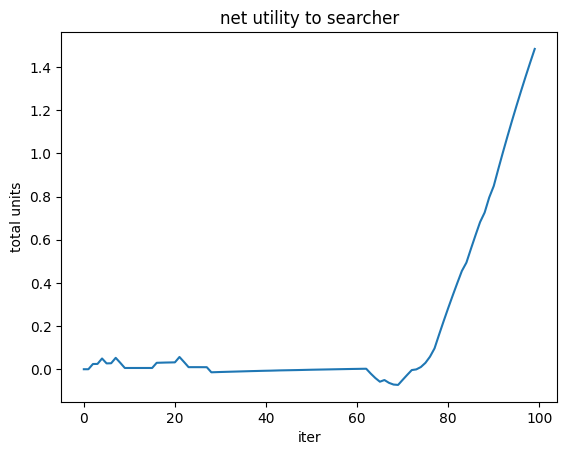

In [11]:
print('Scenario 3: sandwiches')
scenario2(do_frontruns=True)
plt.show()